In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import math
from marswinds.utils import radian_to_degree, degree_to_radian
from tensorflow.keras.models import load_model
import joblib
from os import listdir
from os.path import isfile, join

In [2]:
dune_test_path = '../raw_data/images/testing/dunes'
no_dune_test_path = '../raw_data/images/testing/no_dunes'
base_folder='../raw_data/trained_models'

regressor = load_model(f'{base_folder}/regressor.h5')
regressor_2 = load_model(f'{base_folder}/almost_final.h5')
final_regressor = load_model(f'{base_folder}/final.h5')
regressor_dir = load_model(f'{base_folder}/wind_direction.h5')
classifier = load_model(f'{base_folder}/classifier.h5')
scaler = joblib.load(f'{base_folder}/scaler.lib')

/Users/cedric/.pyenv/versions/marswinds/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# Testing the regressor

In [3]:
test_files = [f for f in listdir(dune_test_path) if len(f)>30]
test_files

['21.26750068664551_49.7474983215332_021_CW000_-0.46574658155441284_-0.7453307509422302_2.059357166290283.jpg',
 '25.687500762939454_27.047500228881837_023_CW000_-0.9113928079605103_0.05076518654823303_2.305976629257202.jpg',
 '17.957499313354493_45.307499694824216_021_CW000_-0.18906854093074799_-0.7375072240829468_2.087489366531372.jpg',
 '21.942499542236327_51.14749984741211_031_CW000_-0.6997101306915283_-0.5268574953079224_1.9518530368804932.jpg',
 '19.237500762939455_47.067501831054685_01_CW000_-0.20449663698673248_-0.8018671870231628_2.1900315284729004.jpg',
 '19.16250076293945_46.14250030517578_030_CW000_-0.05183742940425873_-0.7814042568206787_2.3391456604003906.jpg',
 '17.457499313354493_45.88249816894531_020_CW000_-0.29441502690315247_-0.7210420966148376_1.8764872550964355.jpg',
 '19.087500381469727_47.09250183105469_022_CW000_-0.2237136960029602_-0.7975105047225952_2.185014247894287.jpg',
 '26.167500305175782_23.10250015258789_022_CW000_-0.5812627673149109_-0.5440924763679504

In [4]:
def get_label(image_name):
    parts = image_name[:-4].split('_')
    sin = float(parts[-3])
    cos = float(parts[-2])
    angle = radian_to_degree(math.atan2(sin, cos))
    wind_strength = float(parts[-1])
    
    return(wind_strength, angle)

In [5]:
labels = [get_label(f) for f in test_files]
labels

[(2.059357166290283, -147.999323401774),
 (2.305976629257202, -86.81188130312769),
 (2.087489366531372, -165.62122061312337),
 (1.9518530368804932, -126.97848088751468),
 (2.1900315284729004, -165.69307252037078),
 (2.3391456604003906, -176.20462719261215),
 (1.8764872550964355, -157.7888841562634),
 (2.185014247894287, -164.3303926190748),
 (2.088409185409546, -133.1082179752102),
 (1.9987354278564453, -130.46405805753315),
 (1.9943571090698242, -148.3305820868745),
 (1.9866714477539062, -125.87920542947336),
 (1.9017021656036377, -116.61542870522194),
 (1.8634003400802612, -100.96734666080566),
 (2.270188093185425, 178.9280647700407),
 (2.2007901668548584, 172.54037092706173),
 (1.8151183128356934, -110.72676325609417),
 (2.2780473232269287, -175.60078899575754),
 (1.9031673669815063, -107.32957790910199),
 (1.9228026866912842, -142.98260697486262),
 (2.2173662185668945, 172.14937831978872),
 (2.0700831413269043, -144.02199776361354),
 (1.9671698808670044, -126.55661900471978),
 (1.7

In [14]:
def prediction_from_models(image_name):
        image_path = f'{dune_test_path}/{image_name}'
        try:
            image = cv2.imread(image_path)
            grey_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) / 255.0
            expanded = np.expand_dims(np.expand_dims(grey_image,axis=0), axis=3)
            predicted_regressed = final_regressor.predict(expanded)[0]
            wind_strength = predicted_regressed[0]
            sin = predicted_regressed[2] # Changed to match Aris code
            cos = predicted_regressed[1]
            angle_rad = math.atan2(sin, cos)
        except Exception as e:
            print(f'Problem with file {image_path}')
            print(e)
            return (np.nan,np.nan)
        
        return (scaler.inverse_transform([[wind_strength]])[0][0], radian_to_degree(angle_rad))

In [15]:
from tqdm import tqdm

log_name = '../raw_data/logs/testing_regressor_2.csv'
d = {'filename':[],
    'angular_diff':[],
    'speed_diff':[],
    'predicted_angle':[],
    'actual_angle':[]}

df = pd.DataFrame.from_dict(d).to_csv(log_name, index=False)

def get_diff(files):
    
    for file in tqdm(files):
        pred_wind, pred_angle = prediction_from_models(file)
        label_wind, label_angle = get_label(file)
        
        wind_diff = np.abs(label_wind-pred_wind)
        angle_diff = np.abs(label_angle-pred_angle)
        if angle_diff > 180: angle_diff = 360-angle_diff
            
        d = {'filename':[file],
        'angular_diff':[angle_diff**2],
        'speed_diff':[wind_diff**2],
    'predicted_angle':[pred_angle],
    'actual_angle':[label_angle]}

        pd.concat([pd.read_csv(log_name), pd.DataFrame.from_dict(d)]).to_csv(log_name, index=False)
    
    return pd.read_csv(log_name)
        
        

In [16]:
get_diff(test_files)


100%|██████████| 13961/13961 [35:38<00:00,  6.53it/s]


,filename,angular_diff,speed_diff,predicted_angle,actual_angle
0,21.26750068664551_49.7474983215332_021_CW000_-...,266.107061,8.303696e-04,-164.312112,-147.999323
1,25.687500762939454_27.047500228881837_023_CW00...,5786.249731,8.186311e-03,-10.744479,-86.811881
2,17.957499313354493_45.307499694824216_021_CW00...,27707.654366,1.313003e-02,27.922616,-165.621221
3,21.942499542236327_51.14749984741211_031_CW000...,19698.265896,2.773232e-02,13.372030,-126.978481
4,19.237500762939455_47.067501831054685_01_CW000...,14.530752,2.091349e-02,-169.504995,-165.693073
...,...,...,...,...,...
13956,22.117499923706056_49.34750061035156_01_CW000_...,476.929909,2.763880e-03,-161.438178,-139.599453
13957,20.867499160766602_51.022501373291014_020_CW00...,87.175345,1.104898e-03,-147.801613,-138.464839
13958,18.937499618530275_46.26749877929687_01_CW000_...,26.625736,2.764139e-01,-175.980942,-170.820928
13959,26.3424991607666_22.802500915527343_032_CW000_...,8829.453123,1.742156e-02,135.302437,-130.732393


In [17]:
res = pd.read_csv(log_name)

np.sqrt(res.angular_diff.mean())

68.68603337177406

In [18]:
bad_res = res[res.angular_diff>100**2]

In [19]:
bad_res.drop_duplicates()

,filename,angular_diff,speed_diff,predicted_angle,actual_angle
2,17.957499313354493_45.307499694824216_021_CW00...,27707.654366,0.013130,27.922616,-165.621221
3,21.942499542236327_51.14749984741211_031_CW000...,19698.265896,0.027732,13.372030,-126.978481
6,17.457499313354493_45.88249816894531_020_CW000...,30326.471262,0.004275,16.356088,-157.788884
12,27.957500076293947_22.422499084472655_00_CW000...,24019.917504,0.015473,88.400967,-116.615429
15,19.762499237060545_45.59250183105469_032_CW000...,31323.334906,0.065977,-10.475633,172.540371
...,...,...,...,...,...
13939,26.212500762939452_25.722500228881835_010_CW00...,16546.658832,0.068381,21.382819,-107.250997
13946,21.867499160766602_51.17249984741211_022_CW000...,20785.031494,0.001418,16.311509,-127.858638
13948,19.4875_46.89250106811524_022_CW000_-0.1261089...,12255.259110,0.033314,-60.421856,-171.125330
13951,19.212500762939452_45.742498779296874_010_CW00...,16871.539081,0.084493,-51.296251,178.813261


In [22]:
image_path = f'{dune_test_path}/{bad_res.loc[20,"filename"]}'

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(cv2.imread(image_path), cmap='Greys')

KeyError: 20

In [23]:
np.sqrt(res.angular_diff.mean())

68.68603337177406

In [24]:
mrse_wind_model = np.sqrt(res.speed_diff.mean())

<AxesSubplot:>

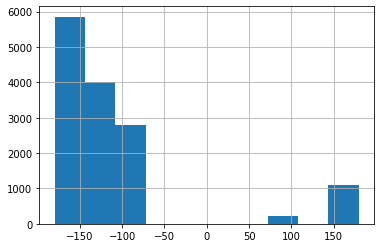

In [38]:
res.actual_angle.hist()

<AxesSubplot:>

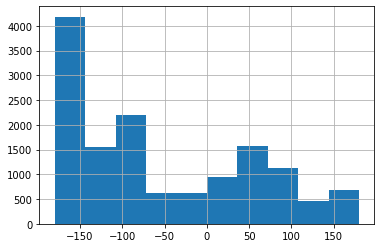

In [39]:
res.predicted_angle.hist()

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

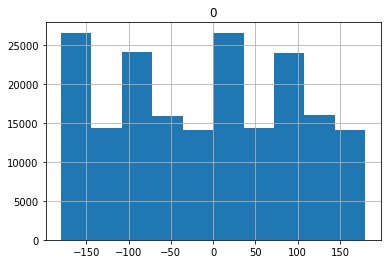

In [26]:
dune_train_path = '../raw_data/images/training/dunes'
train_files = [f for f in listdir(dune_train_path) if len(f)>30]
train_labels_direction = [get_label(f)[1] for f in train_files]
pd.DataFrame(train_labels_direction).hist()

### Performance of wind direction prediction model

In [27]:
mean_wind_dir = np.mean(train_labels_direction)
mrse_base_wind_dir = np.sqrt(np.mean((np.array(train_labels_direction)-mean_wind_dir)**2))
mrse_model_wind_dir = np.sqrt(res.angular_diff.mean())

print(f'MRSE our model: {mrse_model_wind_dir}')
print(f'MRSE base prediction: {mrse_base_wind_dir}')

MRSE our model: 68.68603337177406
MRSE base prediction: 104.09537855498087


### Performance of wind strength prediction model

In [28]:
wind_directions_training = [get_label(f)[0] for f in train_files]

mean_wind_direction = np.mean(wind_directions_training)

base_model_score = np.sqrt(np.mean((np.array(wind_directions_training)-mean_wind_direction)**2))
base_model_score

0.36327340002751357

In [45]:
print(f'MRSE our model: {mrse_wind_model}')
print(f'MRSE base prediction: {base_model_score}')

MRSE our model: 0.34568669380720196
MRSE base prediction: 0.36327340002751357


## Testing Sin/Cos model only

In [49]:
def get_diff_direction(files):
    
    for file in files:
        pred_angle = predict_direction_from_models(file)
        label_wind, label_angle = get_label(file)
        angle_diff = np.abs(label_angle-pred_angle)
        if angle_diff > 180: angle_diff = 360-angle_diff
            
        d = {'filename':[file],
        'angular_diff':[angle_diff**2],
        'predicted_angle':[pred_angle],
        'actual_angle':[label_angle]}

        pd.concat([pd.read_csv(log_name), pd.DataFrame.from_dict(d)]).to_csv(log_name, index=False)
    
    return pd.read_csv(log_name)
        
        

In [55]:
def predict_direction_from_models(image_name):
        image_path = f'{dune_test_path}/{image_name}'
        try:
            image = cv2.imread(image_path)
            grey_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) / 255.0
            expanded = np.expand_dims(np.expand_dims(grey_image,axis=0), axis=3)
            predicted_regressed = regressor_dir.predict(expanded)[0]
            sin = predicted_regressed[1] # Changed to match Aris code
            cos = predicted_regressed[0]
            angle_rad = math.atan2(sin, cos)
        except:
            print(f'Problem with file {image_path}')
            return (np.nan,np.nan)
        
        return (radian_to_degree(angle_rad))

In [58]:
log_name = '../raw_data/logs/testing_wind_dir_regressor.csv'

d = {'filename':[],
    'angular_diff':[],
    'predicted_angle':[],
    'actual_angle':[]}

df = pd.DataFrame.from_dict(d).to_csv(log_name, index=False)

dune_test_path = '../raw_data/images/testing/dunes'

test_wind_dir_files = [f for f in listdir(dune_test_path) if len(f)>30]

In [59]:
df = get_diff_direction(test_wind_dir_files)
df

,filename,angular_diff,predicted_angle,actual_angle
0,21.26750068664551_49.7474983215332_021_CW000_-...,85.698298,-157.256661,-147.999323
1,25.687500762939454_27.047500228881837_023_CW00...,31629.055221,95.342525,-86.811881
2,17.957499313354493_45.307499694824216_021_CW00...,22376.228176,44.791921,-165.621221
3,21.942499542236327_51.14749984741211_031_CW000...,25555.257238,32.881637,-126.978481
4,19.237500762939455_47.067501831054685_01_CW000...,68.043773,-157.444208,-165.693073
...,...,...,...,...
13956,22.117499923706056_49.34750061035156_01_CW000_...,172.799143,-152.744762,-139.599453
13957,20.867499160766602_51.022501373291014_020_CW00...,33.803958,-132.650722,-138.464839
13958,18.937499618530275_46.26749877929687_01_CW000_...,444.318715,-149.742059,-170.820928
13959,26.3424991607666_22.802500915527343_032_CW000_...,2070.797273,-176.238407,-130.732393


In [60]:

mrse_model_wind_dir_sin_cos = np.sqrt(df.angular_diff.mean())

print(f'MRSE our model: {mrse_model_wind_dir_sin_cos}')
print(f'MRSE base prediction: {mrse_base_wind_dir}')

MRSE our model: 84.03495176314753
MRSE base prediction: 104.09537855498087


# Testing the Classifier

In [3]:
def prediction_from_classifier(image_name):
        image_path = f'{dune_test_path}/{image_name}'
        try:
            image = cv2.imread(image_path)
            grey_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) / 255.0
            expanded = np.expand_dims(np.expand_dims(grey_image,axis=0), axis=3)
            predicted_proba = classifier.predict(expanded)[0][0]
            if predicted_proba > 0.5:
                predicted_class = 'dunes'
            else:
                predicted_class = 'no_dunes'
        except:
            print(f'Problem with file {image_path}')
            return (np.nan,np.nan)
        
        return (predicted_proba, predicted_class)

In [4]:
log_name = '../raw_data/logs/testing_classifier2.csv'
d = {'filename':[],
    'actual_class':[],
    'predicted_class':[],
    'predicted_proba':[]}

df = pd.DataFrame.from_dict(d).to_csv(log_name, index=False)

def get_class(files, label):
    
    for file in files:
        pred_proba, pred_class = prediction_from_classifier(file)

            
        d = {'filename':[file],
        'actual_class':[label],
        'predicted_class':[pred_class],
        'predicted_proba':[pred_proba]}

        pd.concat([pd.read_csv(log_name), pd.DataFrame.from_dict(d)]).to_csv(log_name, index=False)
    
    return pd.read_csv(log_name)

In [5]:
dune_test_path = '../raw_data/images/testing/dunes'
no_dune_test_path = '../raw_data/images/testing/no_dunes'

is_dune_files = ('dunes', [f for f in listdir(dune_test_path) if len(f)>30])
no_dune_files = ('no_dunes',[f for f in listdir(no_dune_test_path) if len(f)>30])

In [6]:
log_name = '../raw_data/logs/testing_classifier.csv'

for files in [is_dune_files,no_dune_files]:
    get_class(files[1], files[0])


Problem with file ../raw_data/images/testing/dunes/31.87450065612793_61.73271789550781_030_CW000_-0.8876993060112_0.27692607045173645_4.731226921081543.jpg
Problem with file ../raw_data/images/testing/dunes/34.09350051879883_56.06179275512695_030_CW000_-0.6013681292533875_-0.4364713430404663_1.966863751411438.jpg
Problem with file ../raw_data/images/testing/dunes/40.595499420166014_77.0048812866211_030_CW000_-0.7803475260734558_0.5782200694084167_1.1328470706939697.jpg
Problem with file ../raw_data/images/testing/dunes/38.13549957275391_96.28695526123047_00_CW000_-0.20896528661251068_0.882768452167511_1.398188591003418.jpg
Problem with file ../raw_data/images/testing/dunes/14.932500076293945_47.75750045776367_011_CW000_0.588310182094574_-0.3480420708656311_2.059981107711792.jpg
Problem with file ../raw_data/images/testing/dunes/43.34250030517578_107.110498046875_03_CW000_-0.4392402470111847_0.6916735768318176_2.1830339431762695.jpg
Problem with file ../raw_data/images/testing/dunes/25.

Problem with file ../raw_data/images/testing/dunes/44.59449844360351_109.60599670410156_023_CW000_-0.4599796533584595_0.6089715957641602_1.6961402893066406.jpg
Problem with file ../raw_data/images/testing/dunes/41.01749954223633_102.06750183105468_01_CW000_0.45719489455223083_0.2626607418060303_1.375308871269226.jpg
Problem with file ../raw_data/images/testing/dunes/40.72050170898437_76.40466918945313_020_CW000_0.4125034213066101_0.5424414873123169_0.8603050112724304.jpg
Problem with file ../raw_data/images/testing/dunes/40.820500183105466_76.87980804443359_023_CW000_-0.3190050423145294_0.5989899635314941_0.529788076877594.jpg
Problem with file ../raw_data/images/testing/dunes/38.743498992919925_68.46789245605468_011_CW000_-0.6329362392425537_-0.0822913646697998_0.4633278548717499.jpg
Problem with file ../raw_data/images/testing/dunes/38.535501098632814_95.81149749755859_01_CW000_0.24601466953754425_0.7194265723228455_1.275434970855713.jpg
Problem with file ../raw_data/images/testing/d

Problem with file ../raw_data/images/testing/dunes/31.62449951171875_62.03284683227539_010_CW000_-0.8556678295135498_0.2971683144569397_3.934854030609131.jpg
Problem with file ../raw_data/images/testing/dunes/38.28550033569336_96.186865234375_020_CW000_0.004880859050899744_0.8867989778518677_1.5097514390945435.jpg
Problem with file ../raw_data/images/testing/dunes/31.974501037597655_61.782717895507815_032_CW000_-0.8816138505935669_0.26300087571144104_4.608498573303223.jpg
Problem with file ../raw_data/images/testing/dunes/20.64650077819824_34.03266830444336_012_CW000_-0.8601608872413635_-0.17921343445777893_3.368201971054077.jpg
Problem with file ../raw_data/images/testing/dunes/40.01749877929687_102.10249633789063_022_CW000_0.24153955280780792_0.21609920263290405_1.06755793094635.jpg
Problem with file ../raw_data/images/testing/dunes/31.299500274658204_61.382544708251956_022_CW000_-0.9628475308418274_0.24484972655773163_5.422873020172119.jpg
Problem with file ../raw_data/images/testin

Problem with file ../raw_data/images/testing/dunes/42.84850158691406_100.85372314453124_033_CW000_-0.653212308883667_0.5031079053878784_1.8249260187149048.jpg
Problem with file ../raw_data/images/testing/dunes/31.303500747680665_56.780564880371095_03_CW000_-0.17529793083667755_0.4317544996738434_1.0995070934295654.jpg
Problem with file ../raw_data/images/testing/dunes/43.692501831054685_107.61078033447265_023_CW000_-0.5657927989959717_0.6162134408950806_2.1445159912109375.jpg
Problem with file ../raw_data/images/testing/dunes/44.64449844360352_108.95550231933593_01_CW000_-0.44161590933799744_0.6375353336334229_2.070099115371704.jpg
Problem with file ../raw_data/images/testing/dunes/45.041500854492185_70.6538070678711_020_CW000_-0.18113432824611664_-0.6709339022636414_1.9068721532821655.jpg
Problem with file ../raw_data/images/testing/dunes/31.37450065612793_61.8827621459961_032_CW000_-0.8927316069602966_0.34784722328186035_4.256605625152588.jpg
Problem with file ../raw_data/images/test

Problem with file ../raw_data/images/testing/dunes/43.26750030517578_107.58578033447266_032_CW000_-0.336900919675827_0.7136653661727905_1.9742761850357056.jpg
Problem with file ../raw_data/images/testing/dunes/43.19850082397461_100.82872314453125_012_CW000_-0.24657216668128967_0.8413830399513245_2.2217018604278564.jpg
Problem with file ../raw_data/images/testing/dunes/38.63549957275391_96.13677520751953_02_CW000_0.1708187609910965_0.8070891499519348_1.4546841382980347.jpg
Problem with file ../raw_data/images/testing/dunes/33.893499755859374_56.23683319091797_033_CW000_-0.3906455934047699_-0.4254516661167145_1.5940691232681274.jpg
Problem with file ../raw_data/images/testing/dunes/38.410498809814456_96.63722534179688_012_CW000_0.03490131348371506_0.8277473449707031_1.4033863544464111.jpg
Problem with file ../raw_data/images/testing/dunes/43.46750106811523_107.13555755615235_030_CW000_-0.49531522393226624_0.6957945823669434_2.3344295024871826.jpg
Problem with file ../raw_data/images/test

Problem with file ../raw_data/images/testing/dunes/40.595499420166014_77.15491027832032_032_CW000_-0.7930852770805359_0.556473433971405_1.1645958423614502.jpg
Problem with file ../raw_data/images/testing/dunes/15.752499771118163_49.932498168945315_012_CW000_0.23317432403564453_-0.6723043322563171_1.5492827892303467.jpg
Problem with file ../raw_data/images/testing/dunes/19.8924991607666_33.81675033569336_011_CW000_-0.8738033175468445_-0.11709754168987274_3.705632209777832.jpg
Problem with file ../raw_data/images/testing/dunes/20.871499633789064_34.257833099365236_03_CW000_-0.808279275894165_-0.284757137298584_3.379659652709961.jpg
Problem with file ../raw_data/images/testing/dunes/44.71950073242188_109.08058471679688_012_CW000_-0.3530530035495758_0.667420506477356_2.020052671432495.jpg
Problem with file ../raw_data/images/testing/dunes/39.29350128173828_67.84255828857422_030_CW000_0.5573350191116333_-0.08065690845251083_0.7278502583503723.jpg
Problem with file ../raw_data/images/testing

Problem with file ../raw_data/images/testing/dunes/41.17049942016602_76.92984466552734_01_CW000_0.07071025669574738_-0.12174086272716522_0.6477588415145874.jpg
Problem with file ../raw_data/images/testing/dunes/21.116500091552734_16.46059913635254_012_CW000_-0.35357558727264404_-0.5766075849533081_1.0990289449691772.jpg
Problem with file ../raw_data/images/testing/dunes/20.641500091552736_16.81080093383789_00_CW000_-0.7365004420280457_0.14443030953407288_0.5568229556083679.jpg
Problem with file ../raw_data/images/testing/dunes/20.671500778198244_34.00766830444336_01_CW000_-0.8601608872413635_-0.17921343445777893_3.368201971054077.jpg
Problem with file ../raw_data/images/testing/dunes/45.09150085449219_70.52865753173828_03_CW000_-0.15549689531326294_-0.6650609970092773_1.904170274734497.jpg
Problem with file ../raw_data/images/testing/dunes/40.695501708984374_75.92950134277343_031_CW000_0.5467350482940674_0.5771613121032715_1.3074040412902832.jpg
Problem with file ../raw_data/images/tes

Problem with file ../raw_data/images/testing/dunes/38.618500518798825_67.86755828857422_021_CW000_-0.8349546790122986_0.13389672338962555_0.5502012372016907.jpg
Problem with file ../raw_data/images/testing/dunes/43.84250030517578_107.83594360351563_00_CW000_-0.5789913535118103_0.5506714582443237_1.8655177354812622.jpg
Problem with file ../raw_data/images/testing/dunes/20.641500091552736_17.16095085144043_02_CW000_-0.48802709579467773_0.4733189046382904_0.5603674650192261.jpg
Problem with file ../raw_data/images/testing/dunes/41.12049942016601_76.65474243164063_022_CW000_0.44775301218032837_-0.025391191244125366_0.7543943524360657.jpg
Problem with file ../raw_data/images/testing/dunes/31.653500366210938_57.30596771240234_020_CW000_-0.8312428593635559_0.44442984461784363_1.7424017190933228.jpg
Problem with file ../raw_data/images/testing/dunes/15.35250015258789_49.50750045776367_011_CW000_0.4600646197795868_-0.5812029242515564_1.5211749076843262.jpg
Problem with file ../raw_data/images/t

Problem with file ../raw_data/images/testing/dunes/15.777499771118164_49.60749893188476_01_CW000_0.18295039236545563_-0.6365237236022949_1.6104437112808228.jpg
Problem with file ../raw_data/images/testing/dunes/44.99149856567383_70.42857513427734_03_CW000_-0.14516392350196838_-0.6476145386695862_1.860705018043518.jpg
Problem with file ../raw_data/images/testing/dunes/39.86750183105469_101.87749938964843_01_CW000_0.2873193621635437_0.32382693886756897_1.1569023132324219.jpg
Problem with file ../raw_data/images/testing/dunes/20.391499328613282_16.73574905395508_021_CW000_-0.6116777062416077_0.035889215767383575_0.648766815662384.jpg
Problem with file ../raw_data/images/testing/dunes/14.70750026702881_48.207498168945314_023_CW000_0.6126409769058228_-0.2340208739042282_1.2610050439834595.jpg
Problem with file ../raw_data/images/testing/dunes/33.1135009765625_63.97579803466797_030_CW000_-0.0788906067609787_-0.204548642039299_0.8351045250892639.jpg
Problem with file ../raw_data/images/testin

Problem with file ../raw_data/images/testing/dunes/32.788499450683595_64.3509536743164_03_CW000_-0.501689612865448_0.6559579968452454_0.7979852557182312.jpg
Problem with file ../raw_data/images/testing/dunes/20.696499252319335_34.00766830444336_031_CW000_-0.8621965646743774_-0.18088172376155853_3.3785696029663086.jpg
Problem with file ../raw_data/images/testing/dunes/15.157499885559082_48.282500457763675_02_CW000_0.530726969242096_-0.27493077516555786_2.1112582683563232.jpg
Problem with file ../raw_data/images/testing/dunes/26.4075008392334_40.57661743164063_02_CW000_0.04499298706650734_0.18263471126556396_1.3432600498199463.jpg
Problem with file ../raw_data/images/testing/dunes/40.72050170898437_76.90484466552735_020_CW000_-0.6864979267120361_0.6544946432113647_0.8831303119659424.jpg
Problem with file ../raw_data/images/testing/dunes/33.54349822998047_56.03674850463867_013_CW000_-0.3704032003879547_-0.24735252559185028_1.3345098495483398.jpg
Problem with file ../raw_data/images/testin

Problem with file ../raw_data/images/testing/dunes/20.316500854492187_16.48559913635254_013_CW000_-0.09725315868854523_0.20584911108016968_0.6866973638534546.jpg
Problem with file ../raw_data/images/testing/dunes/42.54849853515625_100.20350341796875_031_CW000_-0.7220994830131531_0.34775468707084656_1.7212841510772705.jpg
Problem with file ../raw_data/images/testing/dunes/42.59849853515625_101.00379638671875_011_CW000_-0.6087461709976196_0.21150092780590057_1.2210578918457031.jpg
Problem with file ../raw_data/images/testing/dunes/20.441499328613283_16.93585090637207_01_CW000_-0.5764865875244141_0.18182383477687836_0.4804065227508545.jpg
Problem with file ../raw_data/images/testing/dunes/44.86950149536133_109.13066711425782_030_CW000_-0.27590587735176086_0.6779554486274719_1.911336898803711.jpg
Problem with file ../raw_data/images/testing/dunes/44.84449920654297_109.60599670410156_03_CW000_-0.3621758818626404_0.6434014439582825_1.7163724899291992.jpg
Problem with file ../raw_data/images/

Problem with file ../raw_data/images/testing/dunes/41.195501708984374_76.20460357666016_030_CW000_0.2607017755508423_-0.24212777614593506_0.8278721570968628.jpg
Problem with file ../raw_data/images/testing/dunes/20.591500091552735_16.6356990814209_021_CW000_-0.6486546993255615_0.08520163595676422_0.6117581725120544.jpg
Problem with file ../raw_data/images/testing/dunes/26.4075008392334_40.476557922363284_02_CW000_0.10147184878587723_0.25305336713790894_1.401072382926941.jpg
Problem with file ../raw_data/images/testing/dunes/31.35349922180176_57.25590057373047_022_CW000_-0.6969814896583557_0.6346865892410278_1.2112970352172852.jpg
Problem with file ../raw_data/images/testing/dunes/38.535501098632814_96.31195526123047_01_CW000_0.17541654407978058_0.8127560615539551_1.4691311120986938.jpg
Problem with file ../raw_data/images/testing/dunes/33.21349945068359_64.15084991455078_033_CW000_-0.10783100128173828_-0.27949056029319763_0.9294078350067139.jpg
Problem with file ../raw_data/images/test

Problem with file ../raw_data/images/testing/dunes/20.846499633789062_33.83249969482422_012_CW000_-0.9146891236305237_-0.0756167620420456_3.583883285522461.jpg
Problem with file ../raw_data/images/testing/dunes/44.94450149536133_109.45591430664062_01_CW000_-0.3180440068244934_0.6565249562263489_1.7250334024429321.jpg
Problem with file ../raw_data/images/testing/dunes/43.56749954223633_107.26060943603515_031_CW000_-0.5396078824996948_0.6689233779907227_2.3593597412109375.jpg
Problem with file ../raw_data/images/testing/dunes/33.288499450683595_64.00079803466797_01_CW000_-0.02712608315050602_-0.4054909646511078_0.9594680666923523.jpg
Problem with file ../raw_data/images/testing/dunes/31.55349998474121_57.08076629638672_023_CW000_-0.6080315709114075_0.6878101825714111_1.0920239686965942.jpg
Problem with file ../raw_data/images/testing/dunes/33.363501739501956_63.850701904296876_013_CW000_-0.2792373597621918_-0.41813185811042786_0.7775893807411194.jpg
Problem with file ../raw_data/images/t

Problem with file ../raw_data/images/testing/dunes/31.974501037597655_61.60762939453125_033_CW000_-0.9056329131126404_0.3107823431491852_5.024990558624268.jpg
Problem with file ../raw_data/images/testing/dunes/15.35250015258789_49.65749893188477_013_CW000_0.46625402569770813_-0.5746061205863953_1.4636377096176147.jpg
Problem with file ../raw_data/images/testing/dunes/20.391499328613282_16.36054916381836_022_CW000_-0.06521864980459213_0.15649478137493134_0.6092240214347839.jpg
Problem with file ../raw_data/images/testing/dunes/43.02350006103516_100.20350341796875_01_CW000_-0.6626680493354797_0.4268427789211273_1.7242262363433838.jpg
Problem with file ../raw_data/images/testing/dunes/31.37450065612793_61.43258514404297_030_CW000_-0.9479904174804688_0.27951526641845703_5.437341690063477.jpg
Problem with file ../raw_data/images/testing/dunes/43.167501831054686_107.21055755615234_033_CW000_-0.38510793447494507_0.7082982659339905_2.125148057937622.jpg
Problem with file ../raw_data/images/tes

Problem with file ../raw_data/images/testing/dunes/43.542501068115236_107.3856689453125_02_CW000_-0.5084171891212463_0.6681925654411316_2.1849076747894287.jpg
Problem with file ../raw_data/images/testing/dunes/20.54149971008301_16.78574905395508_03_CW000_-0.6785840392112732_0.05545015260577202_0.6573966145515442.jpg
Problem with file ../raw_data/images/testing/dunes/43.71750183105469_107.3856689453125_012_CW000_-0.5689128041267395_0.6423789262771606_2.355210304260254.jpg
Problem with file ../raw_data/images/testing/dunes/41.320500183105466_76.25460357666016_022_CW000_0.28683432936668396_-0.2100602388381958_0.8476980328559875.jpg
Problem with file ../raw_data/images/testing/dunes/31.378499221801757_57.1558334350586_012_CW000_-0.6473767161369324_0.6402140259742737_1.0926613807678223.jpg
Problem with file ../raw_data/images/testing/dunes/33.44349975585938_56.111792755126956_012_CW000_-0.4501940608024597_-0.06743151694536209_1.1663837432861328.jpg
Problem with file ../raw_data/images/testi

Problem with file ../raw_data/images/testing/dunes/20.821499633789063_33.85749969482422_023_CW000_-0.9146891236305237_-0.0756167620420456_3.583883285522461.jpg
Problem with file ../raw_data/images/testing/dunes/44.84449920654297_109.38083190917969_02_CW000_-0.33580848574638367_0.6632636785507202_1.8371663093566895.jpg
Problem with file ../raw_data/images/testing/dunes/38.13549957275391_95.98668518066407_00_CW000_-0.407829612493515_0.8472695350646973_1.3741267919540405.jpg
Problem with file ../raw_data/images/testing/dunes/42.398501586914065_101.1038330078125_011_CW000_-0.36165499687194824_0.17034883797168732_1.0835613012313843.jpg
Problem with file ../raw_data/images/testing/dunes/20.591500091552735_16.760749053955077_022_CW000_-0.7230864763259888_-0.0019386454951018095_0.599372148513794.jpg
Problem with file ../raw_data/images/testing/dunes/33.31350173950195_63.525550079345706_032_CW000_-0.8359847068786621_-0.22614561021327972_0.8922041654586792.jpg
Problem with file ../raw_data/image

Problem with file ../raw_data/images/testing/dunes/25.682500076293945_40.42655792236328_010_CW000_0.09549535065889359_0.3240325152873993_1.4849518537521362.jpg
Problem with file ../raw_data/images/testing/dunes/42.923501586914064_100.57864990234376_00_CW000_-0.675938606262207_0.500434160232544_1.9753309488296509.jpg
Problem with file ../raw_data/images/testing/dunes/39.018498229980466_68.31778106689453_023_CW000_0.32978352904319763_-0.3847227990627289_0.3380875885486603.jpg
Problem with file ../raw_data/images/testing/dunes/42.34850158691406_100.57864990234376_030_CW000_-0.5230313539505005_0.3490811586380005_1.3080353736877441.jpg
Problem with file ../raw_data/images/testing/dunes/15.102500343322754_49.83249969482422_032_CW000_0.6504278182983398_-0.47019436955451965_1.0947129726409912.jpg
Problem with file ../raw_data/images/testing/dunes/41.37050018310547_77.12991027832031_01_CW000_0.4720132350921631_0.00903276726603508_0.6998651027679443.jpg
Problem with file ../raw_data/images/testi

Problem with file ../raw_data/images/testing/dunes/41.12049942016601_76.55470581054688_022_CW000_0.4803626835346222_-0.010953057557344437_0.7996968030929565.jpg
Problem with file ../raw_data/images/testing/dunes/42.62349853515625_101.1288330078125_02_CW000_-0.5958533883094788_0.17627762258052826_1.1922990083694458.jpg
Problem with file ../raw_data/images/testing/dunes/33.6135009765625_63.725650024414065_032_CW000_-0.5965145826339722_-0.14967745542526245_1.0601316690444946.jpg
Problem with file ../raw_data/images/testing/dunes/21.021500396728516_34.18283309936523_020_CW000_-0.8183461427688599_-0.27958765625953674_3.453178644180298.jpg
Problem with file ../raw_data/images/testing/dunes/26.23250045776367_40.651676940917966_031_CW000_-0.009873449802398682_0.11496395617723465_1.2901782989501953.jpg
Problem with file ../raw_data/images/testing/dunes/38.843501281738284_67.84255828857422_010_CW000_-0.3350638449192047_-0.1139078214764595_0.2567577362060547.jpg
Problem with file ../raw_data/imag

Problem with file ../raw_data/images/testing/dunes/29.230500411987304_16.75649948120117_012_CW000_-0.4958956241607666_-0.2636813819408417_1.9415779113769531.jpg
Problem with file ../raw_data/images/testing/dunes/20.466499710083006_16.33554916381836_031_CW000_-0.16095563769340515_0.17761968076229095_0.5812479257583618.jpg
Problem with file ../raw_data/images/testing/dunes/26.4075008392334_40.55161743164062_01_CW000_0.04499298706650734_0.18263471126556396_1.3432600498199463.jpg
Problem with file ../raw_data/images/testing/dunes/38.535501098632814_95.8364974975586_02_CW000_0.24601466953754425_0.7194265723228455_1.275434970855713.jpg
Problem with file ../raw_data/images/testing/dunes/33.94349975585938_55.486542510986325_011_CW000_-0.8246844410896301_0.0980977863073349_2.1433112621307373.jpg
Problem with file ../raw_data/images/testing/dunes/14.757500267028808_47.85749893188476_01_CW000_0.6285747289657593_-0.3254481256008148_1.4163028001785278.jpg
Problem with file ../raw_data/images/testin

Problem with file ../raw_data/images/testing/dunes/14.632499885559081_48.15749816894531_011_CW000_0.7591392397880554_-0.15973423421382904_1.0777760744094849.jpg
Problem with file ../raw_data/images/testing/dunes/39.21849899291992_68.19272155761719_022_CW000_0.6848342418670654_-0.0026261217426508665_0.7519969344139099.jpg
Problem with file ../raw_data/images/testing/dunes/44.34449920654297_109.65608673095703_01_CW000_-0.2641898989677429_0.6325899958610535_1.3895773887634277.jpg
Problem with file ../raw_data/images/testing/dunes/14.682500267028809_48.182498168945315_032_CW000_0.6126409769058228_-0.2340208739042282_1.2610050439834595.jpg
Problem with file ../raw_data/images/testing/dunes/31.778500747680663_57.13083343505859_011_CW000_-0.7081820964813232_0.5840337872505188_1.5030890703201294.jpg
Problem with file ../raw_data/images/testing/dunes/43.167501831054686_107.085498046875_032_CW000_-0.3970525562763214_0.6987496018409729_2.124063491821289.jpg
Problem with file ../raw_data/images/te

Problem with file ../raw_data/images/testing/dunes/40.567501831054685_101.76749877929687_021_CW000_0.33976122736930847_0.22724643349647522_1.1576907634735107.jpg
Problem with file ../raw_data/images/testing/dunes/26.182500076293945_40.476557922363284_012_CW000_0.09911572188138962_0.35176339745521545_1.4056788682937622.jpg
Problem with file ../raw_data/images/testing/dunes/31.37450065612793_61.30750045776367_033_CW000_-0.9638761878013611_0.24762189388275146_5.716521739959717.jpg
Problem with file ../raw_data/images/testing/dunes/31.7745002746582_61.23250045776367_030_CW000_-0.9337172508239746_0.3349795639514923_5.970757484436035.jpg
Problem with file ../raw_data/images/testing/dunes/40.445498657226565_76.72977905273437_011_CW000_-0.7555796504020691_0.5836139917373657_1.2902488708496094.jpg
Problem with file ../raw_data/images/testing/dunes/44.46949996948242_109.38083190917969_032_CW000_-0.5645065307617188_0.5564512014389038_1.8319741487503052.jpg
Problem with file ../raw_data/images/tes

Problem with file ../raw_data/images/testing/dunes/31.603499984741212_56.93069915771484_01_CW000_-0.4845132827758789_0.7173264026641846_0.9956381916999817.jpg
Problem with file ../raw_data/images/testing/dunes/32.96350021362305_63.750650024414064_013_CW000_-0.36001458764076233_-0.17866620421409607_0.6506954431533813.jpg
Problem with file ../raw_data/images/testing/dunes/41.49550094604492_76.50470581054688_030_CW000_0.6960700750350952_0.052124351263046265_0.9985663890838623.jpg
Problem with file ../raw_data/images/testing/dunes/42.423501586914064_100.7286865234375_02_CW000_-0.4656716287136078_0.33532214164733887_1.255114197731018.jpg
Problem with file ../raw_data/images/testing/dunes/40.470498657226564_76.02953796386718_01_CW000_-0.3332139849662781_0.8002609014511108_1.0968306064605713.jpg
Problem with file ../raw_data/images/testing/dunes/43.07349853515625_101.1288330078125_022_CW000_-0.3312939703464508_0.7593549489974976_1.8075082302093506.jpg
Problem with file ../raw_data/images/test

Problem with file ../raw_data/images/testing/dunes/34.16850051879883_56.111792755126956_02_CW000_-0.6013681292533875_-0.4364713430404663_1.966863751411438.jpg
Problem with file ../raw_data/images/testing/dunes/45.09150085449219_70.25350036621094_00_CW000_-0.17122940719127655_-0.6595162749290466_1.8802216053009033.jpg
Problem with file ../raw_data/images/testing/dunes/14.582499885559082_47.782500457763675_032_CW000_0.6773824691772461_-0.3964672088623047_1.3065567016601562.jpg
Problem with file ../raw_data/images/testing/dunes/42.423501586914064_101.1288330078125_02_CW000_-0.36165499687194824_0.17034883797168732_1.0835613012313843.jpg
Problem with file ../raw_data/images/testing/dunes/41.52050094604492_76.27960357666015_023_CW000_0.3551017642021179_-0.15645503997802734_0.8742583394050598.jpg
Problem with file ../raw_data/images/testing/dunes/40.945498657226565_77.10491027832032_010_CW000_-0.7576347589492798_0.4062907099723816_0.8573728203773499.jpg
Problem with file ../raw_data/images/te

Problem with file ../raw_data/images/testing/dunes/40.99249954223633_101.9925033569336_012_CW000_0.42783841490745544_0.25636911392211914_1.327000379562378.jpg
Problem with file ../raw_data/images/testing/dunes/20.36649932861328_16.46059913635254_032_CW000_-0.16867341101169586_0.21569600701332092_0.6603161096572876.jpg
Problem with file ../raw_data/images/testing/dunes/26.007499313354494_40.826795959472655_00_CW000_0.029128888621926308_0.05440368130803108_1.3052104711532593.jpg
Problem with file ../raw_data/images/testing/dunes/45.41649856567383_70.32850036621093_033_CW000_-0.154693141579628_-0.664530873298645_1.9085493087768555.jpg
Problem with file ../raw_data/images/testing/dunes/31.40349922180176_57.13083343505859_01_CW000_-0.6473767161369324_0.6402140259742737_1.0926613807678223.jpg
Problem with file ../raw_data/images/testing/dunes/33.468499755859376_55.361498260498045_00_CW000_-0.70892333984375_0.33195340633392334_1.3386222124099731.jpg
Problem with file ../raw_data/images/testin

Problem with file ../raw_data/images/testing/dunes/29.03049964904785_17.232125091552735_011_CW000_-0.49946773052215576_-0.2143469601869583_1.7926068305969238.jpg
Problem with file ../raw_data/images/testing/dunes/19.592499923706054_34.092123413085936_010_CW000_-0.7919952273368835_-0.1618201583623886_3.509389638900757.jpg
Problem with file ../raw_data/images/testing/dunes/43.26750030517578_107.46072082519531_031_CW000_-0.3642835021018982_0.720122218132019_2.0803771018981934.jpg
Problem with file ../raw_data/images/testing/dunes/33.6135009765625_63.67565002441406_030_CW000_-0.5965145826339722_-0.14967745542526245_1.0601316690444946.jpg
Problem with file ../raw_data/images/testing/dunes/43.24250183105469_107.43572082519532_00_CW000_-0.30510076880455017_0.7323349118232727_2.0478405952453613.jpg
Problem with file ../raw_data/images/testing/dunes/33.81850128173828_55.386498260498044_021_CW000_-0.8217553496360779_0.1607774943113327_1.945356011390686.jpg
Problem with file ../raw_data/images/te

Problem with file ../raw_data/images/testing/dunes/43.64249954223633_107.23560943603516_00_CW000_-0.5396078824996948_0.6689233779907227_2.3593597412109375.jpg
Problem with file ../raw_data/images/testing/dunes/44.84449920654297_109.68108673095703_02_CW000_-0.37335702776908875_0.6285127997398376_1.648990273475647.jpg
Problem with file ../raw_data/images/testing/dunes/38.893499755859374_68.1427215576172_030_CW000_-0.09005609899759293_-0.2842573821544647_0.31090104579925537.jpg
Problem with file ../raw_data/images/testing/dunes/38.91849975585937_68.1427215576172_020_CW000_-0.09005609899759293_-0.2842573821544647_0.31090104579925537.jpg
Problem with file ../raw_data/images/testing/dunes/32.98850021362305_63.725650024414065_02_CW000_-0.36001458764076233_-0.17866620421409607_0.6506954431533813.jpg
Problem with file ../raw_data/images/testing/dunes/45.516500854492186_70.92896423339843_033_CW000_-0.1376262903213501_-0.6878644824028015_1.9643235206604004.jpg
Problem with file ../raw_data/images

Problem with file ../raw_data/images/testing/dunes/44.294499206542966_109.63108673095704_020_CW000_-0.2641898989677429_0.6325899958610535_1.3895773887634277.jpg
Problem with file ../raw_data/images/testing/dunes/33.86850128173828_55.56158294677734_00_CW000_-0.8350712060928345_0.10379926860332489_1.9671274423599243.jpg
Problem with file ../raw_data/images/testing/dunes/15.727499771118165_50.00750045776367_021_CW000_0.26796954870224_-0.6638981699943542_1.5738214254379272.jpg
Problem with file ../raw_data/images/testing/dunes/31.94950065612793_61.53262939453125_00_CW000_-0.9131856560707092_0.30446940660476685_5.2162251472473145.jpg
Problem with file ../raw_data/images/testing/dunes/41.445498657226565_76.97984466552734_013_CW000_0.6769541501998901_0.02883663959801197_0.9926735758781433.jpg
Problem with file ../raw_data/images/testing/dunes/39.29350128173828_68.1427215576172_030_CW000_0.6467134356498718_-0.11366710066795349_0.7770617008209229.jpg
Problem with file ../raw_data/images/testing

Problem with file ../raw_data/images/testing/dunes/44.41950149536133_109.65608673095703_011_CW000_-0.41784754395484924_0.5990960001945496_1.4728094339370728.jpg
Problem with file ../raw_data/images/testing/dunes/21.116500091552734_16.23549919128418_011_CW000_-0.2559588849544525_-0.817025363445282_1.3681243658065796.jpg
Problem with file ../raw_data/images/testing/dunes/33.41849975585937_55.386498260498044_021_CW000_-0.70892333984375_0.33195340633392334_1.3386222124099731.jpg
Problem with file ../raw_data/images/testing/dunes/32.7634994506836_64.07584991455079_010_CW000_-0.5056102871894836_0.6342415809631348_0.8027263283729553.jpg
Problem with file ../raw_data/images/testing/dunes/44.41950149536133_109.30574951171874_013_CW000_-0.5390908718109131_0.5483506321907043_1.7570863962173462.jpg
Problem with file ../raw_data/images/testing/dunes/42.423501586914064_100.60364990234375_01_CW000_-0.5230313539505005_0.3490811586380005_1.3080353736877441.jpg
Problem with file ../raw_data/images/testi

Problem with file ../raw_data/images/testing/dunes/31.35349922180176_57.230900573730466_021_CW000_-0.6969814896583557_0.6346865892410278_1.2112970352172852.jpg
Problem with file ../raw_data/images/testing/dunes/20.766500854492186_16.53564910888672_031_CW000_-0.5957452058792114_0.08138704299926758_0.612690269947052.jpg
Problem with file ../raw_data/images/testing/dunes/41.37050018310547_77.10491027832032_00_CW000_0.4720132350921631_0.00903276726603508_0.6998651027679443.jpg
Problem with file ../raw_data/images/testing/dunes/41.445498657226565_76.75477905273438_012_CW000_0.6956762075424194_0.04067382961511612_1.0818815231323242.jpg
Problem with file ../raw_data/images/testing/dunes/20.891499328613282_16.53564910888672_021_CW000_-0.6154614686965942_-0.12207043915987015_0.682747483253479.jpg
Problem with file ../raw_data/images/testing/dunes/15.277499771118164_49.73250122070313_02_CW000_0.5339168310165405_-0.5314602851867676_1.2582452297210693.jpg
Problem with file ../raw_data/images/testi

Problem with file ../raw_data/images/testing/dunes/43.21750183105469_107.26060943603515_011_CW000_-0.36938050389289856_0.7169845700263977_2.117690086364746.jpg
Problem with file ../raw_data/images/testing/dunes/31.57449951171875_62.08284683227539_032_CW000_-0.8556678295135498_0.2971683144569397_3.934854030609131.jpg
Problem with file ../raw_data/images/testing/dunes/29.10550003051758_17.132000732421876_021_CW000_-0.50916987657547_-0.1964150071144104_1.8493682146072388.jpg
Problem with file ../raw_data/images/testing/dunes/20.54149971008301_16.560649108886718_02_CW000_-0.3883780241012573_0.1885625123977661_0.6620272397994995.jpg
Problem with file ../raw_data/images/testing/dunes/31.62449951171875_61.75771789550781_011_CW000_-0.9027343392372131_0.3084760010242462_4.7700300216674805.jpg
Problem with file ../raw_data/images/testing/dunes/31.39950065612793_61.85776214599609_021_CW000_-0.8927316069602966_0.34784722328186035_4.256605625152588.jpg
Problem with file ../raw_data/images/testing/d

Problem with file ../raw_data/images/testing/dunes/33.48850021362305_63.62559814453125_02_CW000_-0.8236797451972961_-0.12355146557092667_0.9487302899360657.jpg
Problem with file ../raw_data/images/testing/dunes/31.35349922180176_56.73056488037109_021_CW000_-0.22673991322517395_0.5100675225257874_1.04258131980896.jpg
Problem with file ../raw_data/images/testing/dunes/25.957499313354493_40.55161743164062_021_CW000_0.07508638501167297_0.32369768619537354_1.383949875831604.jpg
Problem with file ../raw_data/images/testing/dunes/33.21349945068359_63.4755500793457_030_CW000_-0.7278525829315186_-0.4196597933769226_0.7802976369857788.jpg
Problem with file ../raw_data/images/testing/dunes/31.57849998474121_56.980699157714845_013_CW000_-0.4845132827758789_0.7173264026641846_0.9956381916999817.jpg
Problem with file ../raw_data/images/testing/dunes/42.54849853515625_100.7036865234375_031_CW000_-0.6895604133605957_0.28865087032318115_1.4176580905914307.jpg
Problem with file ../raw_data/images/testin

Problem with file ../raw_data/images/testing/dunes/15.252499771118163_49.88249816894531_010_CW000_0.574704647064209_-0.41313567757606506_1.375328779220581.jpg
Problem with file ../raw_data/images/testing/dunes/31.94950065612793_61.63267364501953_00_CW000_-0.9040991067886353_0.28551948070526123_5.007256031036377.jpg
Problem with file ../raw_data/images/testing/dunes/31.303500747680665_57.28090057373047_03_CW000_-0.6411070823669434_0.6768450140953064_1.0373378992080688.jpg
Problem with file ../raw_data/images/testing/dunes/38.81850128173828_68.24278106689454_020_CW000_-0.37025684118270874_-0.2073788046836853_0.441273033618927.jpg
Problem with file ../raw_data/images/testing/dunes/33.893499755859374_55.46154251098633_030_CW000_-0.8246844410896301_0.0980977863073349_2.1433112621307373.jpg
Problem with file ../raw_data/images/testing/dunes/41.12049942016601_76.8048080444336_020_CW000_0.3028888702392578_-0.07903091609477997_0.6850938200950623.jpg
Problem with file ../raw_data/images/testing/

KeyboardInterrupt: 

In [7]:
results = pd.read_csv(log_name)

In [8]:
results

,filename,actual_class,predicted_class,predicted_proba
0,21.26750068664551_49.7474983215332_021_CW000_-...,dunes,dunes,0.999996
1,25.687500762939454_27.047500228881837_023_CW00...,dunes,dunes,0.896045
2,17.957499313354493_45.307499694824216_021_CW00...,dunes,dunes,0.867366
3,21.942499542236327_51.14749984741211_031_CW000...,dunes,dunes,0.664055
4,19.237500762939455_47.067501831054685_01_CW000...,dunes,dunes,1.000000
...,...,...,...,...
34886,26.592499923706054_22.802500915527343_012_CW00...,dunes,dunes,0.947405
34887,25.887499618530274_26.14749984741211_021_CW000...,dunes,dunes,0.517073
34888,21.917499160766603_50.522501373291014_00_CW000...,dunes,dunes,0.975729
34889,21.617499923706056_49.17249984741211_02_CW000_...,dunes,dunes,0.956272


In [9]:
results.predicted_proba == np.nan

0        False
1        False
2        False
3        False
4        False
         ...  
34886    False
34887    False
34888    False
34889    False
34890    False
Name: predicted_proba, Length: 34891, dtype: bool